In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import os
import random
from tqdm import tqdm
from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima.arima import ARIMA, auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
import tensorflow.keras as keras
import warnings
warnings.simplefilter("ignore")

%load_ext pycodestyle_magic
%pycodestyle_on --ignore E501

time: 1.82 s (started: 2022-08-17 10:59:57 +00:00)


# Prepare data

In [2]:
stock_price_df = pd.read_csv("../../stock08_price.csv")

universe = list(stock_price_df.columns.values[1:])
universe.remove("SP500")
# train data
portfolio_train = ['CELG', 'PXD', 'WAT', 'LH', 'AMGN', 'AOS', 'EFX', 'CRM', 'NEM', 'JNPR', 'LB', 'CTAS', 'MAT', 'MDLZ', 'VLO', 'APH', 'ADM', 'MLM', 'BK', 'NOV', 'BDX', 'RRC', 'IVZ', 'ED', 'SBUX', 'GRMN', 'CI', 'ZION', 'COO', 'TIF', 'RHT', 'FDX', 'LLL', 'GLW', 'GPN', 'IPGP', 'GPC', 'HPQ', 'ADI', 'AMG', 'MTB', 'YUM', 'SYK', 'KMX', 'AME', 'AAP', 'DAL', 'A', 'MON', 'BRK', 'BMY', 'KMB', 'JPM', 'CCI', 'AET', 'DLTR', 'MGM', 'FL', 'HD', 'CLX', 'OKE', 'UPS', 'WMB', 'IFF', 'CMS', 'ARNC', 'VIAB', 'MMC', 'REG', 'ES', 'ITW', 'NDAQ', 'AIZ', 'VRTX', 'CTL', 'QCOM', 'MSI', 'NKTR', 'AMAT', 'BWA', 'ESRX', 'TXT', 'EXR', 'VNO', 'BBT', 'WDC', 'UAL', 'PVH', 'NOC', 'PCAR', 'NSC', 'UAA', 'FFIV', 'PHM', 'LUV', 'HUM', 'SPG', 'SJM', 'ABT', 'CMG', 'ALK', 'ULTA', 'TMK', 'TAP', 'SCG', 'CAT', 'TMO', 'AES', 'MRK', 'RMD', 'MKC', 'WU', 'ACN', 'HIG', 'TEL', 'DE', 'ATVI', 'O', 'UNM', 'VMC', 'ETFC', 'CMA', 'NRG', 'RHI', 'RE', 'FMC', 'MU', 'CB', 'LNT', 'GE', 'CBS', 'ALGN', 'SNA', 'LLY', 'LEN', 'MAA', 'OMC', 'F', 'APA', 'CDNS', 'SLG', 'HP', 'XLNX', 'SHW', 'AFL', 'STT', 'PAYX', 'AIG', 'FOX', 'MA']
# all data
portfolio_all = universe
# all data - train data
portfolio_other = [p for p in universe if p not in portfolio_train]
print(len(portfolio_train), len(portfolio_all), len(portfolio_other))
# paper evaluation set
paper_eva_info = {"paper_eva_1": {"portfolio": ['PRGO', 'MRO', 'ADP', 'HCP', 'FITB', 'PEG', 'SYMC', 'EOG', 'MDT', 'NI'], "file_name": "paper_eva_1_res"},
                  "paper_eva_2": {"portfolio": ['STI', 'COP', 'MCD', 'AON', 'JBHT', 'DISH', 'GS', 'LRCX', 'CTXS', 'LEG'], "file_name": "paper_eva_2_res"},
                  "paper_eva_3": {"portfolio": ['TJX', 'EMN', 'JCI', 'C', 'BIIB', 'HOG', 'PX', 'PH', 'XEC', 'JEC'], "file_name": "paper_eva_3_res"},
                  "paper_eva_4": {"portfolio": ['ROP', 'AZO', 'URI', 'TROW', 'CMCSA', 'SLB', 'VZ', 'MAC', 'ADS', 'MCK'], "file_name": "paper_eva_4_res"},
                  "paper_eva_5": {"portfolio": ['RL', 'CVX', 'SRE', 'PFE', 'PCG', 'UTX', 'NTRS', 'INCY', 'COP', 'HRL'], "file_name": "paper_eva_5_res"}}

pd.to_datetime(stock_price_df['Date'], format='%Y-%m-%d')
stock_price_df = stock_price_df.set_index(pd.DatetimeIndex(stock_price_df['Date']))
# display(stock_price_df)

6:80: E501 line too long (1073 > 79 characters)
13:80: E501 line too long (153 > 79 characters)
14:80: E501 line too long (154 > 79 characters)
15:80: E501 line too long (148 > 79 characters)
16:80: E501 line too long (153 > 79 characters)
17:80: E501 line too long (152 > 79 characters)
20:80: E501 line too long (83 > 79 characters)


150 445 295
time: 109 ms (started: 2022-08-17 10:59:59 +00:00)


In [3]:
# setting of output files
save_raw_corr_data = False
save_arima_resid_data = False

time_period = "_test2"
# paper_eva_implement = "paper_eva_2"
# portfolio_implement = paper_eva_info[paper_eva_implement]['portfolio']
# output_file_name = paper_eva_info[paper_eva_implement]['file_name'] + time_period
# fig_title = paper_eva_implement + time_period
paper_eva_implement = "445_all"
portfolio_implement = portfolio_all
output_file_name =  "445_res" + time_period
fig_title = paper_eva_implement + time_period

8:80: E501 line too long (83 > 79 characters)
12:19: E222 multiple spaces after operator


time: 598 µs (started: 2022-08-17 10:59:59 +00:00)


In [4]:
def gen_unseen_data_corr(portfolio: list, time_period:str = "_test2", ret_date: bool = False) -> "pd.DataFrame, pd.Series | pd.DataFrame":
    tmp_corr = stock_price_df[portfolio[0]].rolling(window=100).corr(stock_price_df[portfolio[1]])
    tmp_corr = tmp_corr.iloc[99::100]
    if time_period == "_test2":
        corr_series = tmp_corr[3:24] # correspond to test2_dataset of original paper
    elif time_period == "_test1" :
        corr_series = tmp_corr[2:23] # correspond to test1_dataset of original paper
    elif time_period == "_dev":
        corr_series = tmp_corr[1:22] # correspond to dev_dataset of original paper
    elif time_period == "_train":
        corr_series = tmp_corr[:21] # correspond to train_dataset of original papaer 
    unseen_data_df = pd.DataFrame(corr_series).reset_index().drop(['Date'], axis=1).T
    if ret_date:
        return unseen_data_df, corr_series
    else:
        return unseen_data_df

ValueError: too many values to unpack (expected 3)

time: 730 µs (started: 2022-08-17 10:59:59 +00:00)


In [5]:
unseen_data_df = gen_unseen_data_corr(['RL', 'CVX'])
unseen_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.301064,0.870396,0.895088,0.803884,0.763552,0.437946,0.671847,0.239142,0.703358,0.74433,...,0.396555,0.246283,0.103744,0.01833,0.188772,0.739464,-0.214199,0.285949,-0.352241,0.32908


# ARIMA model

In [6]:
def arima_model(dataset: "pd.DataFrame", portfolio: list, overview: bool = False) -> ("np.array", "pd.DataFrame", str):
    model_110 = ARIMA(order=(1, 1, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_011 = ARIMA(order=(0, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_111 = ARIMA(order=(1, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_211 = ARIMA(order=(2, 1, 1), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    model_210 = ARIMA(order=(2, 1, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)
    #model_330 = ARIMA(order=(3, 3, 0), out_of_sample_size=0, mle_regression=True, suppress_warnings=True)

    #model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210, "model_330": model_330}
    model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}

    tested_models = []
    arima_model = None
    find_arima_model = False
    residual = []
    for s in np.array(dataset):
        while not find_arima_model:
            try:
                for model_key in model_dict:
                    if model_key not in tested_models:
                        test_model = model_dict[model_key].fit(s)
                        if arima_model is None:
                            arima_model = test_model
                            arima_model_name = model_key
                        elif arima_model.aic() <= test_model.aic():
                            pass
                        else:
                            arima_model = test_model
                            arima_model_name = model_key
                    tested_models.append(model_key)

            except Exception:
                if len(model_dict)-1 != 0:
                    del model_dict[model_key]
                else:
                    print(f"fatal error, {portfolio} doesn't have appropriate arima model")
                    break
            else:
                #model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210, "model_330": model_330}
                model_dict = {"model_110": model_110, "model_011": model_011, "model_111": model_111, "model_211": model_211, "model_210": model_210}
                tested_models.clear()
                find_arima_model = True

        arima_pred = list(arima_model.predict_in_sample())
        arima_pred = [np.mean(arima_pred[1:])] + arima_pred[1:]
        arima_pred = np.clip(np.array(arima_pred), -1, 1)

        res = pd.Series(np.array(s) - arima_pred)
        residual.append(np.array(res)[:20])
        find_arima_model = False
    residual = pd.DataFrame(residual)

    if overview:
        plt.plot(arima_pred, label="arima_pred")
        plt.plot(dataset.T, label="data")
        plt.plot(res, label="res")
        plt.legend()
        plt.show()
        plt.close()

    return arima_pred, residual, arima_model_name

1:80: E501 line too long (119 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
3:80: E501 line too long (105 > 79 characters)
4:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)
7:5: E265 block comment should start with '# '
7:80: E501 line too long (106 > 79 characters)
9:5: E265 block comment should start with '# '
9:80: E501 line too long (162 > 79 characters)
10:80: E501 line too long (137 > 79 characters)
36:80: E501 line too long (91 > 79 characters)
39:17: E265 block comment should start with '# '
39:80: E501 line too long (174 > 79 characters)
40:80: E501 line too long (149 > 79 characters)


# LSTM

In [7]:
class DoubleTanh(Activation):
    def __init__(self, activation, **kwargs):
        super(DoubleTanh, self).__init__(activation, **kwargs)
        self.__name__ = 'double_tanh'


def double_tanh(x):
    return (K.tanh(x) * 2)


# get_custom_objects().update({'double_tanh': DoubleTanh(double_tanh)})

# filepath = './stock_correlation_prediction/models/hybrid_LSTM_20220427/epoch262.h5'
# custom_objects = {"Double_Tanh": DoubleTanh, }
# with keras.utils.custom_object_scope(custom_objects):
#     lstm_model = load_model(filepath)

ori_lstm_weight_filepath = "../rebuild_hybrid_model/models/20220807/epoch_582.h5"
lstm_model = load_model(ori_lstm_weight_filepath, custom_objects={'double_tanh':double_tanh})

2022-08-17 10:59:59.521526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 10:59:59.525539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 10:59:59.525758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-17 10:59:59.526601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

ValueError: too many values to unpack (expected 3)

# Hybrid model

In [8]:
def stl_decompn(corr_series: "pd.Series", overview: bool = False) -> (float, float, float):
    output_resid = 100000
    output_trend = None
    output_period = None
    for p in range(2, 11):
        decompose_result_mult = seasonal_decompose(corr_series, period=p)
        resid_sum = np.abs(decompose_result_mult.resid).mean()
        if output_resid > resid_sum:
            output_resid = resid_sum
            output_trend = decompose_result_mult.trend.dropna()
            output_period = p
    
    reg = LinearRegression().fit(np.arange(len(output_trend)).reshape(-1, 1), output_trend)

    if overview:
        decompose_result_mult = seasonal_decompose(corr_series, period=output_period)
        trend = decompose_result_mult.trend.dropna().reset_index(drop=True)
        plt.figure(figsize=(7, 1))
        plt.plot(trend)
        plt.plot([0, len(trend)], [reg.intercept_, reg.intercept_+len(trend)*reg.coef_])
        plt.title("trend & regression line")
        plt.show()
        plt.close()
        decompose_result_mult.plot()
        plt.show()
        plt.close()

    return output_period, output_resid, output_trend.std(), reg.coef_[0]

1:80: E501 line too long (91 > 79 characters)
12:1: W293 blank line contains whitespace
13:80: E501 line too long (91 > 79 characters)
16:80: E501 line too long (85 > 79 characters)
20:80: E501 line too long (88 > 79 characters)


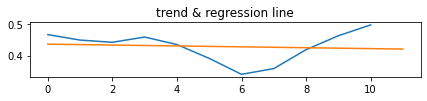

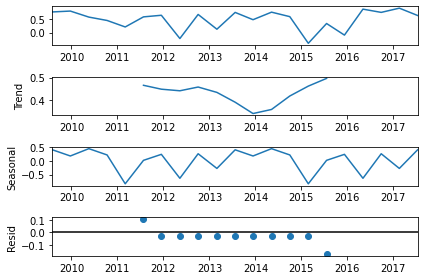

(10, 0.05197403038285887, 0.04734630191453318, -0.0013984760779681504)

1:80: E501 line too long (98 > 79 characters)


In [9]:
unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(['CNP', 'RSG'], ret_date=True)
stl_decompn(unseen_data_corr_series, overview=True)

In [10]:
res_list = []
unseen_data_corr_df_concat = pd.DataFrame(columns=list(range(21))+['portfolio'])
unseen_data_arima_resid_concat = pd.DataFrame(columns=list(range(20))+['portfolio'])
count = 0
for portfolio in tqdm(combinations(portfolio_implement, 2)):
    unseen_data_corr_df, unseen_data_corr_series = gen_unseen_data_corr(portfolio, time_period=time_period, ret_date=True)
    arima_pred, residual, arima_model_name = arima_model(unseen_data_corr_df, portfolio)
    unseen_res = residual.values.reshape((-1, 20, 1))
    lstm_pred = lstm_model.predict(unseen_res)
    season_period, stl_resid, stl_trend_std, coef_reg_trend = stl_decompn(unseen_data_corr_series)
    portfolio_res_dic = {"portfolio": f"{portfolio[0]} & {portfolio[1]}",
                         "corr_ser_mean": unseen_data_corr_series.mean(),
                         "corr_ser_std": unseen_data_corr_series.std(),
                         "corr_season_period": season_period,
                         "corr_stl_resid": stl_resid,
                         "corr_stl_trend_std": stl_trend_std,
                         "corr_trend_coef": coef_reg_trend,
                         "arima_model": arima_model_name,
                         "lstm_pred": lstm_pred[0][0],
                         "arima_pred": arima_pred[-1],
                         "hybrid_model_pred": arima_pred[-1]+lstm_pred[0][0],
                         "ground_truth": unseen_data_corr_df.iloc[0, -1],
                         "arima_err": unseen_data_corr_df.iloc[0, -1] - arima_pred[-1],
                         "error": (unseen_data_corr_df.iloc[0, -1] - (arima_pred[-1]+lstm_pred[0][0])),
                         "absolute_err": math.copysign((unseen_data_corr_df.iloc[0, -1] - (arima_pred[-1]+lstm_pred[0][0])), 1), 
                         "lstm_compensation_dir": np.sign(unseen_data_corr_df.iloc[0, -1] - arima_pred[-1])*np.sign(lstm_pred[0][0])}

    res_list.append(portfolio_res_dic)
    unseen_data_corr_df['portfolio'] = f"{portfolio[0]} & {portfolio[1]}"
    unseen_data_corr_df_concat = pd.concat([unseen_data_corr_df_concat, unseen_data_corr_df]) 
    residual['portfolio'] = f"{portfolio[0]} & {portfolio[1]}"
    unseen_data_arima_resid_concat = pd.concat([unseen_data_arima_resid_concat, residual]) 

if save_raw_corr_data:
    unseen_data_corr_df_concat = unseen_data_corr_df_concat.set_index('portfolio')
    unseen_data_corr_df_concat.to_csv(f"./stock_correlation_prediction/use_hybrid_model/{output_file_name}_raw_corr.csv", index=True)
    
if save_arima_resid_data:
    unseen_data_arima_resid_concat = unseen_data_arima_resid_concat.set_index('portfolio')
    unseen_data_arima_resid_concat.to_csv(f"./stock_correlation_prediction/use_hybrid_model/{output_file_name}_arima_resid.csv", index=True)

0it [00:00, ?it/s]2022-08-17 11:00:01.511465: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
98790it [5:48:20,  4.73it/s]
2:80: E501 line too long (80 > 79 characters)
3:80: E501 line too long (84 > 79 characters)
6:80: E501 line too long (122 > 79 characters)
7:80: E501 line too long (88 > 79 characters)
10:80: E501 line too long (98 > 79 characters)
23:80: E501 line too long (87 > 79 characters)
24:80: E501 line too long (103 > 79 characters)
25:80: E501 line too long (128 > 79 characters)
25:129: W291 trailing whitespace
26:80: E501 line too long (133 > 79 characters)
30:80: E501 line too long (93 > 79 characters)
30:94: W291 trailing whitespace
32:80: E501 line too long (90 > 79 characters)
32:91: W291 trailing whitespace
35:80: E501 line too long (82 > 79 characters)
36:80: E501 line too long (133 > 79 characters)
37:1: W293 blank line contains whitespace
39:80: E501 line too long (90 > 79 characters)
40:80: E501 line too long (140 > 79 characters)


In [11]:
res_df = pd.DataFrame(res_list)
res_df.to_csv(f"./stock_correlation_prediction/use_hybrid_model/{output_file_name}.csv", index=False)

2:80: E501 line too long (101 > 79 characters)


# Display results

In [12]:
res_df = pd.read_csv(f"./stock_correlation_prediction/use_hybrid_model/{output_file_name}.csv")
display(res_df)

,portfolio,corr_ser_mean,corr_ser_std,corr_season_period,corr_stl_resid,corr_stl_trend_std,corr_trend_coef,arima_model,lstm_pred,arima_pred,hybrid_model_pred,ground_truth,arima_err,error,absolute_err,lstm_compensation_dir
0,EXR & RCL,0.457621,0.375633,8,0.077808,0.057065,-0.011513,model_011,-0.286155,0.205255,-0.080900,-0.147673,-0.352928,-0.066773,0.066773,1.0
1,EXR & CLX,0.457273,0.382823,10,0.058197,0.090185,-0.017592,model_011,0.057128,0.306009,0.363137,0.283479,-0.022530,-0.079658,0.079658,-1.0
2,EXR & NSC,0.366751,0.481276,10,0.112220,0.186347,-0.055383,model_211,0.087176,0.055425,0.142601,0.136238,0.080813,-0.006363,0.006363,1.0
3,EXR & CXO,0.318106,0.517407,10,0.064295,0.109238,-0.032370,model_011,0.006966,-0.140021,-0.133055,-0.168771,-0.028750,-0.035717,0.035717,-1.0
4,EXR & AKAM,0.339993,0.494846,10,0.193701,0.081423,-0.013917,model_011,-0.245188,0.101430,-0.143758,0.043027,-0.058403,0.186785,0.186785,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98785,CNP & RSG,0.492231,0.370836,10,0.051974,0.047346,-0.001398,model_011,0.117396,0.481068,0.598464,0.644345,0.163277,0.045881,0.045881,1.0
98786,CNP & DIS,0.227074,0.505718,10,0.037126,0.100746,-0.028354,model_011,-0.144942,-0.044283,-0.189226,-0.219005,-0.174722,-0.029779,0.029779,1.0
98787,ZION & RSG,0.266866,0.402316,10,0.063592,0.103010,-0.028490,model_110,-0.060732,0.269728,0.208996,-0.013980,-0.283708,-0.222976,0.222976,1.0
98788,ZION & DIS,0.428440,0.499489,10,0.069950,0.082897,-0.021728,model_011,-0.591179,0.360776,-0.230403,-0.261509,-0.622285,-0.031106,0.031106,1.0


1:80: E501 line too long (95 > 79 characters)


In [13]:
def res_df_postprocess(target_df: pd.core.frame.DataFrame) -> None:
    target_df['arima_pred_dir'] = np.sign(target_df['ground_truth'] * target_df['arima_pred'])
    target_df['arima_err'] = target_df['ground_truth'] - target_df['arima_pred']
    quantile_mask = np.logical_and(res_df['error'] < np.quantile(res_df['error'], 0.75), res_df['error'] > np.quantile(res_df['error'], 0.25)).tolist()
    display(np.quantile(res_df['error'], 0.75), np.quantile(res_df['error'], 0.25))
    target_df['high_pred_performance'] = quantile_mask
    target_df['portfolio[0]'] = target_df.apply(lambda row:row['portfolio'].split(" & ")[0], axis=1)
    target_df['portfolio[1]'] = target_df.apply(lambda row:row['portfolio'].split(" & ")[1], axis=1)


res_df_postprocess(res_df)
display(res_df)

nan

nan

,portfolio,corr_ser_mean,corr_ser_std,corr_season_period,corr_stl_resid,corr_stl_trend_std,corr_trend_coef,arima_model,lstm_pred,arima_pred,hybrid_model_pred,ground_truth,arima_err,error,absolute_err,lstm_compensation_dir,arima_pred_dir,high_pred_performance,portfolio[0],portfolio[1]
0,EXR & RCL,0.457621,0.375633,8,0.077808,0.057065,-0.011513,model_011,-0.286155,0.205255,-0.080900,-0.147673,-0.352928,-0.066773,0.066773,1.0,-1.0,False,EXR,RCL
1,EXR & CLX,0.457273,0.382823,10,0.058197,0.090185,-0.017592,model_011,0.057128,0.306009,0.363137,0.283479,-0.022530,-0.079658,0.079658,-1.0,1.0,False,EXR,CLX
2,EXR & NSC,0.366751,0.481276,10,0.112220,0.186347,-0.055383,model_211,0.087176,0.055425,0.142601,0.136238,0.080813,-0.006363,0.006363,1.0,1.0,False,EXR,NSC
3,EXR & CXO,0.318106,0.517407,10,0.064295,0.109238,-0.032370,model_011,0.006966,-0.140021,-0.133055,-0.168771,-0.028750,-0.035717,0.035717,-1.0,1.0,False,EXR,CXO
4,EXR & AKAM,0.339993,0.494846,10,0.193701,0.081423,-0.013917,model_011,-0.245188,0.101430,-0.143758,0.043027,-0.058403,0.186785,0.186785,1.0,1.0,False,EXR,AKAM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98785,CNP & RSG,0.492231,0.370836,10,0.051974,0.047346,-0.001398,model_011,0.117396,0.481068,0.598464,0.644345,0.163277,0.045881,0.045881,1.0,1.0,False,CNP,RSG
98786,CNP & DIS,0.227074,0.505718,10,0.037126,0.100746,-0.028354,model_011,-0.144942,-0.044283,-0.189226,-0.219005,-0.174722,-0.029779,0.029779,1.0,1.0,False,CNP,DIS
98787,ZION & RSG,0.266866,0.402316,10,0.063592,0.103010,-0.028490,model_110,-0.060732,0.269728,0.208996,-0.013980,-0.283708,-0.222976,0.222976,1.0,-1.0,False,ZION,RSG
98788,ZION & DIS,0.428440,0.499489,10,0.069950,0.082897,-0.021728,model_011,-0.591179,0.360776,-0.230403,-0.261509,-0.622285,-0.031106,0.031106,1.0,-1.0,False,ZION,DIS


2:80: E501 line too long (94 > 79 characters)
3:80: E501 line too long (80 > 79 characters)
4:80: E501 line too long (151 > 79 characters)
5:80: E501 line too long (83 > 79 characters)


ValueError: too many values to unpack (expected 3)

In [14]:
def plot_exploration(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=7, ncols=2, sharex=False, sharey=False, dpi=100)
    s0 = axes[0, 0]
    s0.set_title("ABS_err violin")
    sns.violinplot(y=target_df["absolute_err"], ax=s0)
    s1 = axes[0, 1]
    s1.set_title("Err violin")
    sns.violinplot(y=target_df["error"], ax=s1)
    s2 = axes[1, 0]
    s2.set_title("ABS_err hist")
    target_df['absolute_err'].hist(bins=[b/10 for b in range(11)], ax=s2)
    s3 = axes[1, 1]
    s3.set_title("Err hist")
    target_df['error'].hist(bins=[b/10 for b in range(-10, 11)], ax=s3)
    s4 = axes[2, 0]
    s4.set_title("LSTM_compensation_dir count")
    sns.countplot(x="lstm_compensation_dir", data=target_df, ax=s4)
    s5 = axes[2, 1]
    s5.set_title("LSTM_compensation_dir count groupby ARIMA_pred_dir")
    df_gb = target_df.groupby(['arima_pred_dir', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s5)
    s6 = axes[3, 0]
    s6.set_title("ARIMA_model prediction Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_err"], ax=s6)
    s8 = axes[4, 0]
    s8.set_title("ARIMA_model prediction magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["arima_pred"], ax=s8)
    s9 = axes[4, 1]
    s9.set_title("LSTM compensation magnitude group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["lstm_pred"], ax=s9)
    s10 = axes[5, 0]
    s10.set_title("Correlation magnitude in last period group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["ground_truth"], ax=s10)
    s11 = axes[5, 1]
    s11.set_title("Hybrid Err violin group by LSTM_compensation_dir")
    sns.violinplot(x=target_df["lstm_compensation_dir"], y=target_df["error"], ax=s11)
    s12 = axes[6,0]
    s12.set_title("LSTM_compensation_dir pie with wrong ARIMA_pred_dir")
    df_gb.loc[df_gb.index==-1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s12)
    s13 = axes[6,1]
    s13.set_title("LSTM_compensation_dir pie with correct ARIMA_pred_dir")
    df_gb.loc[df_gb.index==1, :].squeeze().plot(kind="pie", autopct='%1.1f%%', ax=s13)
    
    fig.suptitle(f"{title}_basic_exploration")
    plt.tight_layout()
    plt.savefig(f"./stock_correlation_prediction/use_hybrid_model/hybrid_prediction_analysis_{title}.png")
    plt.show()
    plt.close()

2:80: E501 line too long (101 > 79 characters)
20:80: E501 line too long (98 > 79 characters)
23:80: E501 line too long (84 > 79 characters)
24:80: E501 line too long (89 > 79 characters)
26:80: E501 line too long (83 > 79 characters)
27:80: E501 line too long (90 > 79 characters)
30:80: E501 line too long (89 > 79 characters)
32:80: E501 line too long (88 > 79 characters)
33:80: E501 line too long (93 > 79 characters)
36:80: E501 line too long (86 > 79 characters)
37:17: E231 missing whitespace after ','
39:26: E225 missing whitespace around operator
39:80: E501 line too long (87 > 79 characters)
40:17: E231 missing whitespace after ','
42:26: E225 missing whitespace around operator
42:80: E501 line too long (86 > 79 characters)
43:1: W293 blank line contains whitespace
46:80: E501 line too long (106 > 79 characters)


In [15]:
def plot_exploration_pred_perform(target_df: pd.core.frame.DataFrame, title: str) -> None:
    fig, axes = plt.subplots(figsize=(20, 20), nrows=6, ncols=2, sharex=False, sharey=False, dpi=100)
    s1 = axes[0, 0]
    s1.set_title("LSTM_compensation_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'lstm_compensation_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s1)
    s2 = axes[0, 1]
    s2.set_title("ARIMA_model prediction magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["arima_pred"], ax=s2)
    s3 = axes[1, 0]
    s3.set_title("LSTM compensation magnitude group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["lstm_pred"], ax=s3)
    s4 = axes[1, 1]
    s4.set_title("Correlation magnitude in last period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["ground_truth"], ax=s4)
    s5 = axes[2, 0]
    s5.set_title("Correlation series mean groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_mean"], ax=s5)
    s6 = axes[2, 1]
    s6.set_title("Correlation series std groupby prediction performance")
    sns.violinplot(x=target_df['high_pred_performance'], y=target_df["corr_ser_std"], ax=s6)
    s7 = axes[3, 0]
    s7.set_title("Correlation series stl_period group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_season_period"], ax=s7)
    s8 = axes[3, 1]
    s8.set_title("Correlation series stl_residual group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_resid"], ax=s8)
    s9 = axes[4, 0]
    s9.set_title("Correlation series stl_trend_std group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_stl_trend_std"], ax=s9)
    s10 = axes[4, 1]
    s10.set_title("Correlation series stl_trend_coef group by prediction performance")
    sns.violinplot(x=target_df["high_pred_performance"], y=target_df["corr_trend_coef"], ax=s10)
    s11 = axes[5, 0]
    s11.set_title("ARIMA_pred_dir count groupby prediction performance")
    df_gb = target_df.groupby(['high_pred_performance', 'arima_pred_dir']).size().unstack(level=1)
    df_gb.plot(kind='bar', ax=s11)

    fig.suptitle(F"{title}_groupby prediction")
    plt.tight_layout()
    plt.savefig(f"./stock_correlation_prediction/use_hybrid_model/hybrid_prediction_analysis_groupby_pred_perform_{title}.png")
    plt.show()
    plt.close()

1:80: E501 line too long (90 > 79 characters)
2:80: E501 line too long (101 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
8:80: E501 line too long (84 > 79 characters)
9:80: E501 line too long (90 > 79 characters)
12:80: E501 line too long (89 > 79 characters)
14:80: E501 line too long (88 > 79 characters)
15:80: E501 line too long (92 > 79 characters)
18:80: E501 line too long (93 > 79 characters)
21:80: E501 line too long (92 > 79 characters)
23:80: E501 line too long (81 > 79 characters)
24:80: E501 line too long (98 > 79 characters)
26:80: E501 line too long (83 > 79 characters)
27:80: E501 line too long (94 > 79 characters)
29:80: E501 line too long (84 > 79 characters)
30:80: E501 line too long (98 > 79 characters)
32:80: E501 line too long (86 > 79 characters)
33:80: E501 line too long (96 > 79 characters)
36:80: E501 line too long (98 > 79 characters)
41:80: E501 line too long (127 > 79 characters)


In [16]:
def plot_stock_freq(target_df: pd.core.frame.DataFrame, title: str) -> None:
    stocks_show_freq = target_df.loc[target_df['high_pred_performance'] == True, ['portfolio[0]','portfolio[1]']].stack().value_counts().to_dict()
    plt.figure(figsize=(80, 10), dpi=100)
    plt.bar(range(len(stocks_show_freq)), list(stocks_show_freq.values()))
    plt.xticks(range(len(stocks_show_freq)), list(stocks_show_freq.keys()), rotation=60)
    plt.title(F"{title}_stock appearence frequence")
    plt.savefig(f"./stock_correlation_prediction/use_hybrid_model/stock_appearence_frequence_{title}.png")
    plt.show()
    plt.close()

ValueError: too many values to unpack (expected 3)

In [17]:
display(f"mse :{(res_df['error']**2).mean()}",
        f"std of square_err :{(res_df['error']**2).std()}",
        f"rmse :{np.sqrt((res_df['error']**2).mean())}",
        f"mae : {res_df['absolute_err'].mean()}",
        f"std of abs_err: {res_df['absolute_err'].std()}")

display(f"sklearn mse: {mean_squared_error(res_df['ground_truth'], res_df['hybrid_model_pred'])}")

'mse :0.02605289462824795'

'std of square_err :0.09226370813822025'

'rmse :0.16140909090955177'

'mae : 0.09415817364823725'

'std of abs_err: 0.13110036973038325'

ValueError: Input contains NaN.

7:80: E501 line too long (98 > 79 characters)


In [ ]:
plot_exploration(res_df, fig_title)

In [ ]:
plot_exploration_pred_perform(res_df, fig_title)

In [ ]:
plot_stock_freq(res_df, fig_title)

In [ ]:
len(set(res_df.loc[res_df['high_pred_performance']==True, ['portfolio[0]','portfolio[1]']].stack()))